In [172]:
# basics
import pandas as pd
import numpy as np
import itertools
import random
import pickle

# vectorizer, classifiers, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split
from sklearn.model_selection import GridSearchCV

# rnn
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

from gensim.models import KeyedVectors

# custom functions, class to import and process data
from get_labeled_dfs import *
from process_text import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [173]:
# use custom function to get the corpus df and labels 
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [174]:
# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [175]:
# after processing, the text in the corpus df is all lower case, free of punctuation (except emotion-relevant exclamation points and question marks), 
# free of numbers, and lemmatized
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,hussein ally hang iraqi official
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [176]:
# The emotion df contains ratings for each emotion, the max rating, and label columns 
# for each emotion with a 1 indicating that the emotion is present (it has a non-zero 
# rating) or a 0 indicating that it is not.  
emotion_df.head()

,anger,disgust,fear,joy,sadness,suprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,suprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


In [177]:
def label_confusion_matrices(lst, df, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(15,10))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(2,3,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

In [178]:
def suite_of_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    
    print('jaccard score average:', round(jaccard_score_samples, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 macro:', round(f1_macro_score, 3))
    

# resample

In [184]:
len(emotion_df.loc[emotion_df['anger_label']==1])

652

In [185]:
len(emotion_df.loc[emotion_df['disgust_label']==1])

525

In [186]:
len(emotion_df.loc[emotion_df['fear_label']==1])

820

In [187]:
len(emotion_df.loc[emotion_df['joy_label']==1])

786

In [188]:
len(emotion_df.loc[emotion_df['sadness_label']==1])

863

In [189]:
len(emotion_df.loc[emotion_df['suprise_label']==1])

1102

In [127]:
# resample all but suprise:
indices = []
    
df = emotion_df.loc[((emotion_df['disgust_label']==1)|(emotion_df['anger_label']==1)) & (emotion_df['suprise_label']==0)]
df_sample = df.sample(200, replace=True, random_state=10)
indices.append(df.index)
    
for i in indices:
    emotion_df = pd.concat((emotion_df, emotion_df.iloc[i, :]), axis=0)
    corpus_df = pd.concat((corpus_df, corpus_df.iloc[i, :]), axis=0)

In [134]:
# create vectors
word2vec = KeyedVectors.load_word2vec_format('/Users/flatironschool/Desktop/Detecting_Emotions/data/GoogleNews-vectors-negative300.bin', \
        binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

Found 3000000 word vectors of word2vec


In [135]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(corpus_df['text']))

In [136]:
# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_data = sequence.pad_sequences(sequences, maxlen=15, padding='post')


In [138]:
# get the data into a 3 dimensional array: number of sentences by max words per sentence (15) by shape of vectors (300)
reshape = padded_data.reshape(20340,1)
zeros = np.zeros((20340, 300))
concatenated = np.concatenate((reshape, zeros), axis=1)
sentence_df = pd.DataFrame(concatenated)

# add the vecors to the dataframe corresponding to the word sequence numbers

for i in range(len(sentence_df)):
    word = sentence_df.loc[i, 0]
    try:
        vec = word2vec[tokenizer.index_word[word]]
        sentence_df.iloc[i, 1:] = vec
    except:
        pass
    


In [139]:
data_matrix = np.array(sentence_df.iloc[:, 1:]).reshape(-1, 15, 300)


In [140]:
data_matrix[data_matrix == 0] = np.nan
mean_sentence_vec = np.nanmean(data_matrix, axis=1)
mean_sentence_vec = np.nan_to_num(mean_sentence_vec)

In [141]:
random.seed(22)
# first split the data into separate training and testing sets using an iterative_train_test_split
# to ensure that labels are distributed as evenly as possibile between the training and test sets
X_train, y_train, X_test, y_test = iterative_train_test_split(mean_sentence_vec, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'suprise_label']].values, test_size=.25)


## One Versus Rest Model

An important consideration in choosing a multilabel prediction model is whether the labels are independent or correlated. There is some moderate correlation between the labels in my dataset.

*Insert pic*

For comparison, I tested methods that treats labels as independent and methods that allows for label correlations. In this notebook, I include:

* One Versus Rest Classifier

A One Versus Rest classifier trains a separate model for each label in the dataset. Each model's predictions are independent of al the others.

For this model, I used a logistic regression classifier.

* Correlated: Chain Classifier

A Chain Classifier trains a model for each label in the dataset, but each model's predictions are transferred to the next model, so the probabistic relationships between labels are taken into account.

For this model, I used a linear support vector classifier.

Chain Classifiers are sensitive to label order, so I tested all 750 possible label orders to find the best one. If my dataset were significantly larger or if I had significantly more label combinations to tested, it would have been too computationally expensive, and thus more practical to do a random selection of label orders to test. 

The Chain Classifier model did have a slight advantage over the One Versus Rest model. 


In [142]:
# lr = LogisticRegression()

# parameters = {
#     'estimator__penalty': ['l1', 'l2'],
#     'estimator__C': [.001, .01, .1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10],
#     'estimator__class_weight': ['balanced', None]
# }

# clf = GridSearchCV(OneVsRestClassifier(lr), parameters, scoring = '', cv=5)
# clf.fit(X_train, y_train)

# print(clf.best_params_, clf.best_score_)

# ovr = clf.best_estimator_.fit(X_train, y_train)
# ovr_test_preds = ovr.predict(X_test)

In [143]:
svc = SVC(class_weight='balanced')

parameters = {
    'estimator__kernel':['rbf', 'poly', 'sigmoid'],
    'estimator__C': [.001, .1, 1, 10, 100],
    'estimator__degree': [3, 4],
    'estimator__coef0': [0.1, 0.5, 1, 1.5, 2],
    'estimator__gamma': [0.1, .05, 1],
}

clf = GridSearchCV(OneVsRestClassifier(svc), parameters, scoring = 'jaccard_macro', cv=5, n_jobs=3)
clf.fit(X_train, y_train)

print(clf.best_params_, clf.best_score_)

svc = clf.best_estimator_.fit(X_train, y_train)
svc_test_preds = svc.predict(X_test)

{'estimator__C': 0.1, 'estimator__coef0': 0.5, 'estimator__degree': 3, 'estimator__gamma': 1, 'estimator__kernel': 'poly'} 0.7012416797325731


In [144]:
svc_preds_df = pd.DataFrame(svc_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
y_test_df = pd.DataFrame(y_test, columns=['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'])
svc_preds_df = pd.concat([svc_preds_df, y_test_df], axis=1)

anger_label accuracy: 0.5183946488294314
anger_label precision: 0.842391304347826
anger_label recall 0.8333333333333334
anger_label f1 0.8378378378378378


disgust_label accuracy: 0.3767123287671233
disgust_label precision: 0.6666666666666666
disgust_label recall 0.7432432432432432
disgust_label f1 0.7028753993610223


fear_label accuracy: 0.6577181208053692
fear_label precision: 0.8711111111111111
fear_label recall 0.8596491228070176
fear_label f1 0.8653421633554084


joy_label accuracy: 0.5559440559440559
joy_label precision: 0.7429906542056075
joy_label recall 0.7832512315270936
joy_label f1 0.762589928057554


sadness_label accuracy: 0.6897689768976898
sadness_label precision: 0.8818565400843882
sadness_label recall 0.885593220338983
sadness_label f1 0.8837209302325582


surprise_label accuracy: 0.8770226537216829
surprise_label precision: 0.9155405405405406
surprise_label recall 0.928082191780822
surprise_label f1 0.9217687074829932




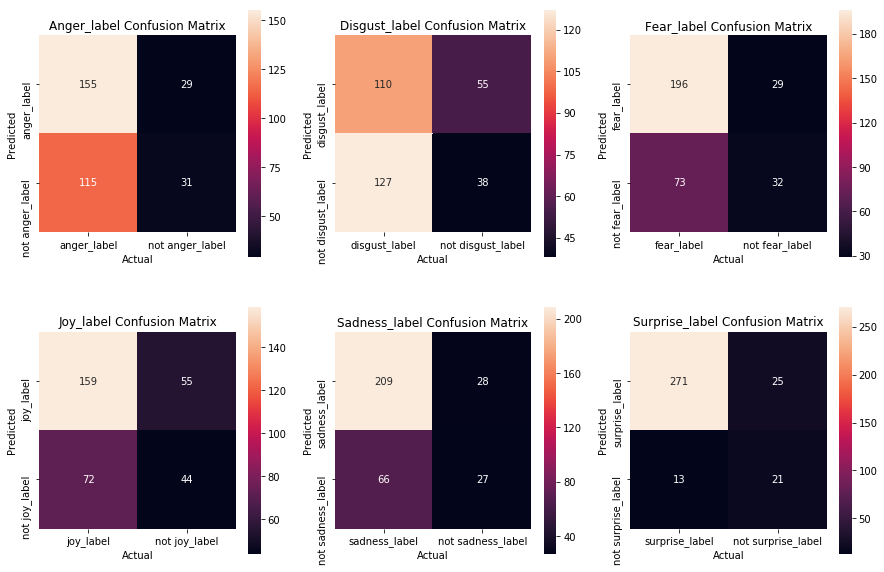

In [145]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], svc_preds_df)


In [146]:
suite_of_scores(y_test, svc_test_preds)


jaccard score average: 0.732
hamming loss: 0.209
f1 macro: 0.829


In [148]:
filename = 'svm_ovr_resample.sav'
pickle.dump(svc, open(filename, 'wb'))

## Classifier Chain

In [150]:
svc = SVC(kernel='poly', C=0.1, coef0=0.5, degree=3, gamma=1, class_weight='balanced')

perms = list(itertools.permutations([0,1,2,3,4,5]))

chains = [ClassifierChain(svc, order=perms[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(X_train, y_train)
    test_preds = chain.predict(X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='samples'))


In [151]:
cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
max(results_jaccard)

0.7227777777777777

In [152]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_test_df], axis=1)

anger_label accuracy: 0.5183946488294314
anger_label precision: 0.842391304347826
anger_label recall 0.8333333333333334
anger_label f1 0.8378378378378378


disgust_label accuracy: 0.38513513513513514
disgust_label precision: 0.6909090909090909
disgust_label recall 0.7702702702702703
disgust_label f1 0.7284345047923323


fear_label accuracy: 0.6530612244897959
fear_label precision: 0.9014084507042254
fear_label recall 0.8421052631578947
fear_label f1 0.8707482993197279


joy_label accuracy: 0.5512367491166078
joy_label precision: 0.7358490566037735
joy_label recall 0.7684729064039408
joy_label f1 0.7518072289156625


sadness_label accuracy: 0.6747404844290658
sadness_label precision: 0.8986175115207373
sadness_label recall 0.826271186440678
sadness_label f1 0.8609271523178808


surprise_label accuracy: 0.8729096989966555
surprise_label precision: 0.9125874125874126
surprise_label recall 0.8938356164383562
surprise_label f1 0.903114186851211




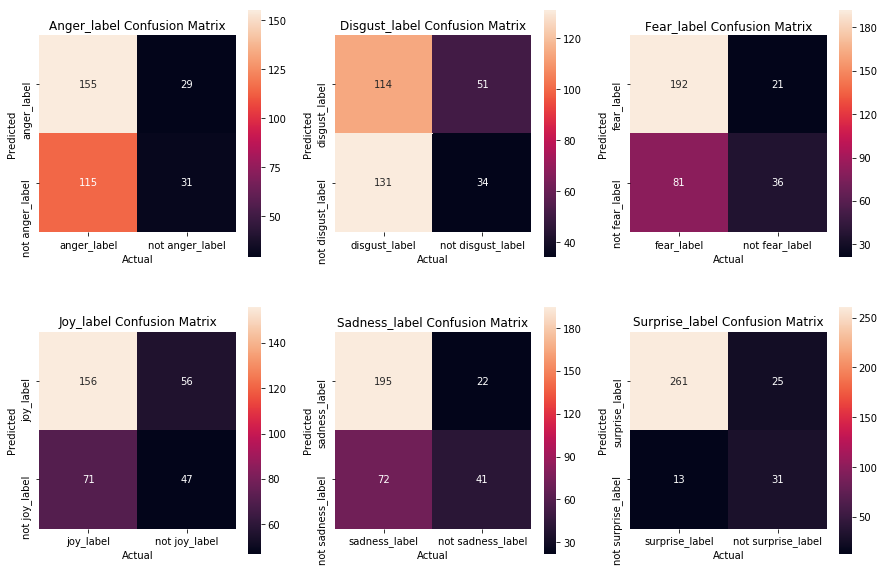

In [153]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [154]:
suite_of_scores(y_test, cc_test_preds.toarray())


jaccard score average: 0.723
hamming loss: 0.214
f1 macro: 0.825


## RNN for Multilabel Classification

In [160]:
# use custom function to get the corpus df and labels 
corpus_df_RNN, _, _ = get_labeled_dfs()

# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df_RNN, RNN=True)

for i in indices:

    corpus_df_RNN = pd.concat((corpus_df_RNN, corpus_df_RNN.iloc[i, :]), axis=0)


In [161]:
# create vectors
word2vec = KeyedVectors.load_word2vec_format('/Users/flatironschool/Desktop/Detecting_Emotions/data/GoogleNews-vectors-negative300.bin', \
        binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(corpus_df_RNN['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df_RNN['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_data = sequence.pad_sequences(sequences, maxlen=15, padding='post')

            

Found 3000000 word vectors of word2vec


In [162]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in word2vec.vocab.keys():
        embedding_matrix[ind + 1, :] = word2vec[word]
        


In [165]:
random.seed(9)
X_train, y_train, X_test, y_test = iterative_train_test_split(padded_data, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'suprise_label']].values, test_size=.25)

# labels multihot encoded
# y_train_multihot = y_train.values
# y_test_multihot = y_test.values


In [166]:
# Check to see that the labels are evenly divided
print('Percent of each label appreaing in the test set')
print("   Anger:", y_test[:,0].sum()/y_train[:,0].sum())
print("   Disgust:", y_test[:,1].sum()/y_train[:,1].sum())
print("   Fear:", y_test[:,2].sum()/y_train[:,2].sum())
print("   Joy:", y_test[:,3].sum()/y_train[:,3].sum())
print("   Sadness", y_test[:,4].sum()/y_train[:,4].sum())
print("   Suprise:", y_test[:,5].sum()/y_train[:,5].sum())

Percent of each label appreaing in the test set
   Anger: 0.3192982456140351
   Disgust: 0.3201754385964912
   Fear: 0.3323529411764706
   Joy: 0.3333333333333333
   Sadness 0.3228021978021978
   Suprise: 0.3521472392638037


In [167]:
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
             ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, save_weights_only=True)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))

model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.0025, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train,
                    epochs=50,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 15, 1: 1}, {0: 20, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test))

W0728 08:55:09.980795 4548609472 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 08:55:10.608324 4548609472 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 08:55:10.631196 4548609472 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 08:55:10.670158 4548609472 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0728 08:55:10.671046 4548609472 deprecation_wrapper

Train on 1026 samples, validate on 330 samples
Epoch 1/50
1026/1026 [==============================] - 3s 3ms/step - loss: 0.6116 - acc: 0.6730 - val_loss: 0.6158 - val_acc: 0.7071
Epoch 2/50
1026/1026 [==============================] - 0s 461us/step - loss: 0.4725 - acc: 0.7895 - val_loss: 0.5688 - val_acc: 0.7470
Epoch 3/50
1026/1026 [==============================] - 0s 453us/step - loss: 0.4058 - acc: 0.8249 - val_loss: 0.6765 - val_acc: 0.6919
Epoch 4/50
1026/1026 [==============================] - 0s 472us/step - loss: 0.3423 - acc: 0.8658 - val_loss: 0.6091 - val_acc: 0.7253
Epoch 5/50
1026/1026 [==============================] - 1s 512us/step - loss: 0.2927 - acc: 0.8887 - val_loss: 0.7346 - val_acc: 0.7187
Epoch 6/50
1026/1026 [==============================] - 0s 465us/step - loss: 0.2515 - acc: 0.9128 - val_loss: 0.5888 - val_acc: 0.7556
Epoch 7/50
1026/1026 [==============================] - 0s 478us/step - loss: 0.2334 - acc: 0.9227 - val_loss: 0.5648 - val_acc: 0.7667
Epo

330/330 [==============================] - 0s 274us/step


[0.5720705064860258, 0.7651515140677944]

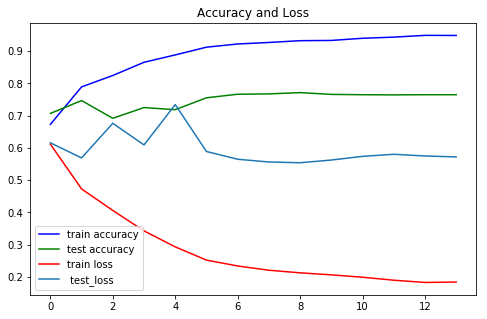

In [168]:
plt.figure(figsize=(8,5))

plt.plot(model.history.history['acc'], color='blue', label='train accuracy')
plt.plot(model.history.history['val_acc'], color='green', label='test accuracy')

plt.plot(model.history.history['loss'], color='red', label='train loss')
plt.plot(model.history.history['val_loss'], label=' test_loss')

plt.title("Accuracy and Loss")
plt.legend()

model.evaluate(X_test, y_test)


In [169]:
model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_suprise":RNN_preds[:,5], "anger":y_test[:,0], "disgust":y_test[:,1], "fear": y_test[:,2], "joy": y_test[:,3], "sadness": y_test[:,4], "suprise": y_test[:,5]})


anger accuracy: 0.48788927335640137
anger precision: 0.7833333333333333
anger recall 0.7747252747252747
anger f1 0.7790055248618786


disgust accuracy: 0.34285714285714286
disgust precision: 0.7111111111111111
disgust recall 0.6575342465753424
disgust f1 0.6832740213523131


fear accuracy: 0.6190476190476191
fear precision: 0.898936170212766
fear recall 0.7477876106194691
fear f1 0.8164251207729469


joy accuracy: 0.5694915254237288
joy precision: 0.7741935483870968
joy recall 0.8275862068965517
joy f1 0.7999999999999999


sadness accuracy: 0.671280276816609
sadness precision: 0.8940092165898618
sadness recall 0.825531914893617
sadness f1 0.8584070796460177


suprise accuracy: 0.8496503496503497
suprise precision: 0.8966789667896679
suprise recall 0.8466898954703833
suprise f1 0.8709677419354839




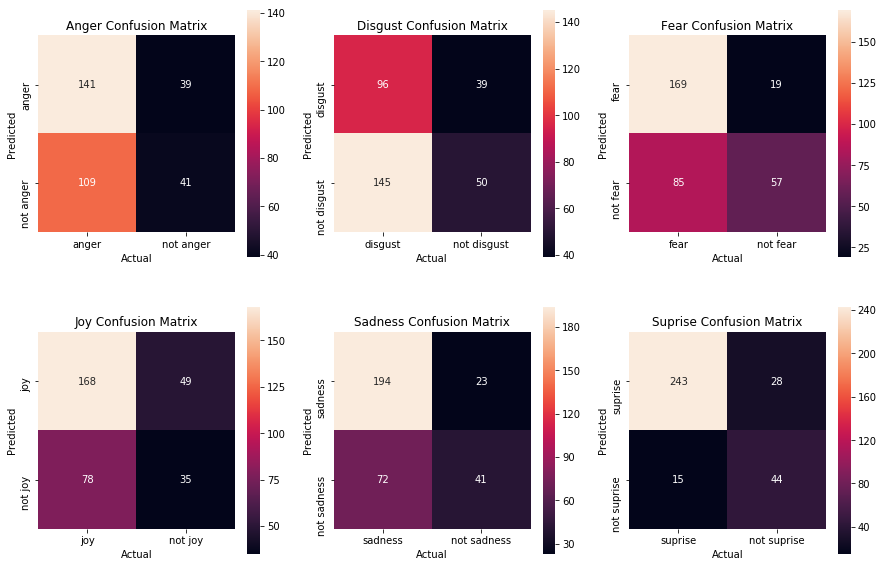

In [170]:
label_confusion_matrices(['anger', 'disgust', 'fear', 'joy', 'sadness', 'suprise'], RNN_preds_df, RNN=True)

In [171]:
suite_of_scores(y_test, RNN_preds>.5)


jaccard score average: 0.692
hamming loss: 0.235
f1 macro: 0.801
